# TL;DR (feat: Agentic RAG 시스템 예제 4종)

이 파일에는 **Agentic RAG 예제 4종**을 한눈에 비교하여 정리합니다.
각 시스템은 동일한 기본 기능을 제공하지만, **Router 방식**과 **Multi-Agent 구조** 적용 여부에 따라 점진적으로 복잡성과 지능 수준이 달라집니다.

| 시스템 이름                 | Router 방식 | Multi-Agent 구조 | 특징 / 설명                                                       |
| ---------------------- | --------- | -------------- | ------------------------------------------------------------- |
| **SimpleAgenticRAG**   | ❌ 없음      | ❌ 단일 Agent     | 가장 단순한 구조. 단일 Agent가 여러 도구를 직접 호출. 초급 학습용.                    |
| **RuleBasedRoutedRAG** | ✅ 규칙 기반   | ❌ 단일 Agent     | 조건문 라우팅. 질문 유형별로 고정된 핸들러에 분기. 규칙 중심의 단순 Router.               |
| **LLMRoutedRAG**       | ✅ LLM 기반  | ❌ 단일 Agent     | Router LLM이 질문을 해석해 도구 선택. 더 유연하고 지능적인 분기 가능.                 |
| **MultiAgentRAG**      | ✅/선택적     | ✅ 다중 Agent     | 각 도구가 독립 Agent로 분리, Supervisor Agent가 협업을 조율. 대규모/복합 시스템에 적합. |


### 핵심 포인트

1. **SimpleAgenticRAG**: 가장 단순한 구조, Agent와 도구 연동만으로 동작
2. **RuleBasedRoutedRAG**: 조건문 기반 분기, 질문 유형별 라우팅을 단순 규칙으로 처리
3. **LLMRoutedRAG**: Router LLM을 활용해 질문을 해석하고 더 유연하게 도구 선택
4. **MultiAgentRAG**: 각 도구를 독립 Agent로 분리, Supervisor가 협업을 관리하는 확장형 구조


> 슬시인들은 4개의 예제를 통해 **단일 Agent → 규칙 기반 라우팅 → LLM 기반 라우팅 → Multi-Agent 협업**으로 이어지는 발전 과정을 직관적으로 확인할 수 있습니다.
> 연구/실습/서비스 규모에 따라 적합한 예제를 선택해 적용할 수 있을 것입니다. 🚀

---

## A. SimpleAgenticRAG

### 1. 환경 설정 및 기본 세팅

#### 환경 변수 설정

이 코드는 `.env` 파일에서 API 키를 읽어와 환경 변수로 설정합니다.  

- `load_dotenv()`  
  - 프로젝트 루트의 `.env` 파일을 읽어 환경 변수를 로드합니다.  

- `os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")`  
  - `.env` 파일에서 OpenAI API 키를 가져와 환경 변수로 설정합니다.  
  - OpenAI API 키를 환경 변수로 설정하여 GPT 모델을 사용할 수 있도록 준비합니다.  

- `os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")`  
  - `.env` 파일에서 Tavily API 키를 가져와 환경 변수로 설정합니다.  
  - Tavily API 키를 환경 변수로 설정하여 Tavily 서비스와 연동할 수 있도록 준비합니다.  

이렇게 하면 중요한 API 키를 코드에 직접 작성하지 않고 안전하게 관리할 수 있습니다.

In [ ]:
import os

from dotenv import load_dotenv

# .env 파일 로드, 환경 변수에서 API 키 읽기
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

#### LLM 및 임베딩 모델 초기화

이 코드는 예제 프로그램에서 사용할 언어 모델(LLM)과 임베딩 모델을 설정합니다.  

- `llm_for_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0)`  
  - **ChatOpenAI**를 이용해 GPT 기반 LLM을 초기화합니다.  
  - `model="gpt-4o-mini"`: 사용할 GPT 모델 지정  
  - `temperature=0`: 출력의 무작위성을 최소화하여 안정적인 결과 생성  
  - 주로 요약, 번역, 질의응답 등 도구 내부에서 활용됩니다.  

- `embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")`  
  - 텍스트를 벡터로 변환하는 **임베딩 모델**을 초기화합니다.  
  - `model="text-embedding-3-small"`: 벡터화에 사용되는 작은 임베딩 모델  
  - 검색, 유사도 계산, 문서 분류 등에서 활용됩니다.  

이렇게 설정된 LLM과 임베딩 모델을 통해 AI Agent가 자연어 처리 및 의미 기반 검색 기능을 수행할 수 있습니다.


In [ ]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# 도구 내부에서 사용할 LLM (요약, 번역 등)
llm_for_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0)
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

### 2. RAG 파이프라인 구축 (문서 로드, 분할, 임베딩, 벡터 스토어 생성)


Agent가 특정 전문 분야에 대해 깊이 있는 답변을 하려면, 해당 분야의 지식을 검색할 수 있는 내부 데이터베이스가 필요합니다.   
이 단계는 "Attention Is All You Need" 논문 PDF를 Agent가 참고할 수 있는 '지식 창고(Vector Store)'로 만드는 과정입니다.

> **요약:** 원본 PDF 문서를 잘게 나누고, 각 조각의 의미를 숫자로 변환하여 검색이 용이한 데이터베이스에 저장함으로써, Agent가 특정 주제에 대해 빠르게 참조할 수 있는 **개인화된 검색 엔진**을 만든 것입니다.

#### 데이터 로드 (Loading)

이 코드는 PDF 파일을 읽어 AI Agent가 사용할 문서 데이터를 준비합니다.

- `pdf_url = "UnderstandingDeepLearning_05_29_25_C.pdf"`  
  - 불러올 PDF 파일 경로 또는 URL 지정  

- `loader = PyPDFLoader(pdf_url)`  
  - **PyPDFLoader**를 사용하여 PDF 파일을 로드할 준비  

- `docs = loader.load()`  
  - PDF를 실제로 읽어 각 페이지를 개별 문서 객체로 변환  
  - `docs`는 페이지 단위로 나누어진 문서 리스트  

- `print(f"- '{docs[0].metadata['source']}' 에서 {len(docs)}개 페이지 로드 완료")`  
  - 로드 완료 확인 및 페이지 수 출력  

> 이 단계는 AI Agent에게 학습시키거나 검색할 원본 지식을 가져오는 **첫걸음**입니다.

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

# 1. 데이터 로드 (PDF)
pdf_url = "UnderstandingDeepLearning_05_29_25_C.pdf"
loader = PyPDFLoader(pdf_url)
docs = loader.load()
print(f"- '{docs[0].metadata['source']}' 에서 {len(docs)}개 페이지 로드 완료")

#### 텍스트 분할 (Splitting)

이 단계에서는 로드한 PDF 문서를 LLM이 효율적으로 처리할 수 있는 작은 단위로 나눕니다.

- `text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)`  
  - **RecursiveCharacterTextSplitter**를 사용해 문서를 청크 단위로 분할  
  - `chunk_size=2000`: 한 청크의 최대 문자 수  
  - `chunk_overlap=200`: 청크 간 일부 내용을 겹치게 하여 문맥 유지  

- `split_docs = text_splitter.split_documents(docs)`  
  - 각 페이지를 정의한 청크 기준으로 분할  
  - 결과는 LLM이 처리 가능한 여러 작은 문서 조각 리스트  

- `print(f"- {len(docs)}개 페이지를 {len(split_docs)}개의 청크로 분할 완료")`  
  - 분할 완료 확인 및 생성된 청크 수 출력  

> 이렇게 하면 문서의 의미가 유지되면서 LLM이 효율적으로 이해하고 처리할 수 있는 단위로 준비됩니다.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 2. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
split_docs = text_splitter.split_documents(docs)
print(f"- {len(docs)}개 페이지를 {len(split_docs)}개의 청크로 분할 완료")

#### 임베딩 및 벡터 스토어 구축 (Embedding & Vector Store)

이 단계에서는 분할된 텍스트 청크를 벡터로 변환하고, 검색 가능한 벡터 스토어를 생성합니다.

#### 임베딩 (Embedding)
- 분할된 텍스트 청크들을 **컴퓨터가 이해할 수 있는 숫자 벡터**로 변환합니다.  
- 임베딩 모델(`embedding_model`)을 사용하여 각 청크의 의미를 벡터 공간에 맵핑합니다.  
- 의미가 비슷한 텍스트는 벡터 공간에서도 **가까운 위치**에 존재하게 됩니다.

#### 벡터 스토어 구축 및 검색기 생성 (Storing & Retrieving)
- **FAISS**를 사용해 벡터를 고속으로 저장하고 인덱싱합니다.  
  - 초기에는 첫 번째 1/4 청크로 벡터 스토어를 생성  
  - 나머지 3/4 청크는 순차적으로 추가하여 전체 문서를 포함  
- `vectorstore.as_retriever()`를 통해 **검색기(Retriever)** 생성  
  - 검색기는 질문 벡터와 가장 가까운 문서 벡터를 찾아 관련 문서를 반환  
  - RAG(Retrieval-Augmented Generation) 파이프라인에서 핵심 역할 수행

> 이렇게 하면, AI Agent는 방대한 문서에서 의미 있는 정보를 신속하게 찾아내고, 이를 기반으로 답변을 생성할 수 있습니다.

In [ ]:
from langchain_community.vectorstores import FAISS

# 3. 벡터 스토어 생성 및 검색기(Retriever) 설정
# split_docs를 4등분하여 FAISS에 순차적으로 추가
chunk_size = len(split_docs) // 4
print(f"- 총 {len(split_docs)}개 청크를 4등분하여 순차적으로 벡터 스토어에 추가")

# 첫 번째 1/4로 벡터 스토어 초기화
first_chunk = split_docs[:chunk_size]
vectorstore = FAISS.from_documents(first_chunk, embedding_model)
print(f"- 1/4 청크 ({len(first_chunk)}개) 초기 벡터 스토어 생성 완료")

# 나머지 3/4을 순차적으로 추가
for i in range(1, 4):
    start_idx = i * chunk_size
    end_idx = start_idx + chunk_size if i < 3 else len(split_docs)  # 마지막 청크는 나머지 모든 문서
    chunk_docs = split_docs[start_idx:end_idx]

    if chunk_docs:  # 빈 청크가 아닌 경우에만 추가
        vectorstore.add_documents(chunk_docs)
        print(f"- {i+1}/4 청크 ({len(chunk_docs)}개) 벡터 스토어에 추가 완료")

retriever = vectorstore.as_retriever()
print("- FAISS 벡터 스토어 및 검색기 생성 완료")
print("RAG 파이프라인 구축 완료")

### 3. 다중 도구(Tools) 생성

Agent는 스스로 웹 검색을 하거나 번역을 할 수 없습니다.   
이러한 기능들은 '도구(Tool)'의 형태로 만들어서 Agent에게 제공해야 합니다.   
이 단계에서는 Agent가 사용할 수 있는 4가지 핵심 능력을 정의하고 구현합니다.

**핵심 원리:**
각 도구에는 **이름(`name`)** 과 **설명(`description`)** 이 있습니다.   
Agent의 두뇌 역할을 하는 LLM은 사용자의 질문을 보고, 각 도구의 '설명'을 읽은 뒤, 어떤 도구를 사용하는 것이 가장 적절할지 판단합니다.    

**따라서 이 설명을 명확하고 상세하게 작성하는 것이 매우 중요합니다.**

#### [도구 1] RAG 검색 도구 (Retriever Tool)

이 코드는 RAG 기반 검색 기능을 AI Agent가 사용할 수 있도록 도구 형태로 만듭니다.

- `retriever_tool = create_retriever_tool(...)`  
  - 2단계에서 만든 **벡터 스토어 기반 검색기 (`retriever`)**를 Agent가 활용할 수 있는 도구로 변환  
  - `"DeepLearningSearch"`: 도구 이름 지정  
  - 설명: 머신러닝/딥러닝 관련 질문을 검색하고 관련 문서를 반환  
    - 최신 논문 내용은 포함되지 않을 수 있음  

- 기능 요약:  
  - Agent는 입력 질문이 책이나 논문과 관련된 경우 이 도구를 호출  
  - 검색 도구는 질문의 의미 벡터와 가장 유사한 문서 청크를 찾아 반환  
  - RAG 파이프라인 내에서 **지식 기반 질문 응답** 역할 수행

> 이렇게 함으로써 AI Agent는 특정 도메인 지식에 대한 정확한 정보를 검색하고 활용할 수 있습니다.

In [ ]:
from langchain.tools.retriever import create_retriever_tool

# --- 도구 1: RAG 검색 도구 ---
retriever_tool = create_retriever_tool(
    retriever,
    "DeepLearningSearch",
    "머신러닝에 관련된 질문을 검색하고 반환합니다. 머신러닝이나 딥러닝에 관련된 질문에 사용해야 합니다. 최신 딥러닝 논문에 대한 내용은 포함되지 않을 수도 있습니다.",
)

#### [도구 2] 웹 검색 도구 (Tavily Tool)

이 코드는 AI Agent가 최신 정보나 일반 상식 질문에 답할 수 있도록 **새로운 TavilySearch 도구**를 초기화합니다 (이전 `TavilySearchResults`는 deprecated).

- `from langchain_tavily import TavilySearch`  
  - `langchain_tavily` 패키지를 사용하여 최신 버전의 Tavily 검색 기능 도입

- `tavily_tool = TavilySearch(...)` 설정 항목:
  - `max_results=5`: 한 번의 검색에서 최대 5개의 결과 반환  
  - `topic="general"`: 일반 (일반 지식) 검색용으로 주제 지정  
  - 설명: 벡터 스토어에 없는 최신 정보나 일반적인 사실 질문에 대응

- 역할 요약:
  - Agent가 실시간 인터넷 정보가 필요한 경우 호출  
  - 정적 지식(예: 벡터 스토어)과 실시간 정보 검색을 결합하여 다양한 질문에 대응 가능

> 참고: `TavilySearchResults`는 deprecated되었으므로 반드시 이 `TavilySearch`로 대체해야 합니다.

In [ ]:
from langchain_tavily import TavilySearch

# --- 도구 2: 웹 검색 도구 ---
tavily_tool = TavilySearch(
    max_results=5,
    topic="general",  # 검색 주제를 "일반"으로 설정 (예: general, news, finance)
    description="최신 정보나 일반적인 사실에 대한 질문에 답하기 위해 웹을 검색합니다. 벡터 스토어에 없는 내용에 사용됩니다.",
)

#### [도구 3] 웹페이지 분석/요약 도구 (process_and_summarize_webpage)

이 코드는 사용자가 제공한 웹페이지 URL을 읽고, 내용을 요약해주는 맞춤형 도구를 정의합니다.

- `@tool`  
  - 일반 Python 함수를 Agent가 사용할 수 있는 **표준 도구**로 변환합니다.  
  - Agent는 이 설명을 보고, 웹페이지 요약이 필요할 때 이 도구를 선택합니다.  

- 함수 동작 과정:
  1. `WebBaseLoader([url])`  
     - URL의 웹페이지 내용을 불러와 LangChain 문서 객체(`docs`)로 변환  
  2. `load_summarize_chain(llm=llm_for_tools, chain_type="stuff")`  
     - 사전에 준비된 LLM(`llm_for_tools`)을 이용하여 요약 체인 생성  
  3. `summary = summarize_chain.invoke(docs)`  
     - 문서를 요약하여 결과 반환  
     - 최신 LangChain(v0.2+)에서는 `run` 대신 `invoke` 사용  
  4. 오류 발생 시 에러 메시지 반환  

- 기능 요약:
  - 사용자가 제공한 웹페이지를 **실시간으로 분석하고 요약**  
  - 최신 기사, 블로그, 연구 노트 등 특정 URL 기반 정보를 빠르게 파악 가능  

> 이 도구는 정적 문서 검색(벡터 스토어)이나 일반 웹 검색(Tavily)과 달리, **특정 URL을 직접 지정하여 요약**할 때 유용합니다.

In [ ]:
from langchain.agents import tool
from langchain.chains.summarize import load_summarize_chain
from langchain_community.document_loaders import WebBaseLoader


# --- 도구 3: 웹페이지 분석/요약 도구 ---
@tool
def process_and_summarize_webpage(url: str):
    """
    사용자가 제공한 URL의 웹페이지 콘텐츠를 로드하여 분석하고 그 내용을 요약합니다.
    URL과 관련된 질문에 답하거나 내용을 요약해야 할 때 사용해야 합니다.
    """
    try:
        loader = WebBaseLoader([url])
        docs = loader.load()
        summarize_chain = load_summarize_chain(llm=llm_for_tools, chain_type="stuff")
        summary = summarize_chain.invoke(docs)  # run 대신 invoke 사용 (LangChain v0.2+)
        return summary
    except Exception as e:
        return f"오류가 발생했습니다: {e}"

#### [도구 4] 번역 도구 (translate_text)

이 코드는 사용자가 요청한 텍스트를 원하는 언어로 번역해주는 도구를 정의합니다.

- `@tool`  
  - 일반 Python 함수를 Agent가 사용할 수 있는 **표준 도구**로 등록합니다.  
  - Agent는 번역 요청이 들어오면 이 도구를 선택하여 실행합니다.  

- 함수 동작 과정:
  1. `ChatPromptTemplate.from_template(...)`  
     - 번역 프롬프트 템플릿 생성  
     - `{target_language}`와 `{text}`를 동적으로 채워, 특정 언어로 번역을 지시  
  2. `translation_chain = prompt | llm_for_tools | StrOutputParser()`  
     - **프롬프트 → LLM → 출력 파서** 순으로 연결된 체인 생성  
     - LLM(`llm_for_tools`)이 번역 수행 후 문자열 결과만 추출  
  3. `translation_chain.invoke({...})`  
     - 실제 입력 텍스트와 대상 언어를 전달하여 번역 실행  
     - 번역된 문자열을 반환  

- 기능 요약:
  - 사용자가 입력한 텍스트를 원하는 언어(예: 영어 → 한국어, 한국어 → 일본어 등)로 번역  
  - LLM 기반 번역이므로 단순 직역이 아니라 문맥에 맞는 자연스러운 번역 가능  

> 이 도구를 통해 AI Agent는 다국어 환경에서도 유연하게 대응할 수 있습니다.

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


# --- 도구 4: 번역 도구 ---
@tool
def translate_text(text: str, target_language: str):
    """
    주어진 텍스트를 지정된 대상 언어로 번역합니다.
    사용자가 번역을 요청할 때 사용해야 합니다.
    """
    prompt = ChatPromptTemplate.from_template("Translate the following text to {target_language}:\n\n{text}")
    translation_chain = prompt | llm_for_tools | StrOutputParser()
    return translation_chain.invoke({"text": text, "target_language": target_language})

### 4. Agent 생성 및 연동

이제 준비된 '지식 창고'와 '도구들'을 사용하여 실제 작업을 수행할 Agent를 조립하고 실행 가능한 형태로 만드는 마지막 단계입니다.

#### 도구 목록 통합 (Tool Integration)

이 단계에서는 앞서 정의한 **4개의 도구**를 하나의 리스트로 묶어, Agent가 활용할 수 있도록 준비합니다.

- `tools = [retriever_tool, tavily_tool, process_and_summarize_webpage, translate_text]`  
  - `retriever_tool`: 딥러닝 문서 전용 RAG 검색 도구  
  - `tavily_tool`: 최신 정보 및 일반 지식 검색을 위한 웹 검색 도구  
  - `process_and_summarize_webpage`: 특정 URL을 불러와 내용을 요약하는 도구  
  - `translate_text`: 주어진 텍스트를 원하는 언어로 번역하는 도구  

- 역할 요약:  
  - Agent는 이 리스트를 **공구함(toolbox)**처럼 사용  
  - 질문의 성격에 따라 가장 적합한 도구를 선택해 실행  
    - 논문 관련 → `retriever_tool`  
    - 최신 소식 → `tavily_tool`  
    - 특정 URL 분석 → `process_and_summarize_webpage`  
    - 다국어 대응 → `translate_text`  

> 모든 도구를 하나의 리스트에 모아두면, Agent가 다양한 상황에 맞게 도구를 조합하여 더 지능적으로 동작할 수 있습니다.

In [ ]:
# 1. 사용할 도구 목록 통합
tools = [retriever_tool, tavily_tool, process_and_summarize_webpage, translate_text]

#### Agent의 두뇌(LLM) 선택 (LLM for Reasoning)

이 단계에서는 Agent가 도구를 선택하고 추론하는 데 사용할 LLM을 정의합니다.

- `agent_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)`  
  - `gpt-4o-mini` 모델을 사용하여 경량이면서도 강력한 추론 능력을 제공  
  - 이 LLM은 사용자의 질문에 직접 답하는 대신,  
    - 질문의 의도를 파악하고  
    - 어떤 도구를 활용해야 할지 **'생각하고 결정하는 역할'**을 수행  

#### Temperature 파라미터 설명
- `temperature=0`:  
  - 모델의 출력이 **일관되고 결정적(deterministic)**  
  - 같은 입력에 대해 항상 같은 도구를 선택하는 안정적인 동작 보장  
  
- `temperature` 값이 커질수록:  
  - 출력의 **랜덤성(randomness)** 증가  
  - 더 창의적인 답변 가능하지만, 도구 선택이 불안정해질 수 있음  

> 💡 **개발자 Tip:**  
> `temperature` 값을 0.3, 0.7, 1.0 등으로 바꿔 실행해보면서 Agent가 도구를 선택하는 방식이 어떻게 달라지는지 직접 실험해보세요.

In [ ]:
# 2. Agent가 추론에 사용할 LLM
agent_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

#### Agent 프롬프트 설정 (Prompting)

이 단계에서는 Agent가 도구를 올바르게 활용할 수 있도록 **행동 지침(Prompt)**을 불러옵니다.

- `prompt = hub.pull("hwchase17/openai-functions-agent")`  
  - LangChain의 **Hub**에서 검증된 프롬프트 템플릿을 가져옴  
  - Agent의 두뇌(LLM)에게 다음과 같은 역할을 부여:  
    - "너는 이제부터 보조원(Assistant)이다.  
       사용자의 질문을 보고 내가 제공한 도구 목록 중 가장 적합한 것을 선택해 실행하고,  
       그 결과를 바탕으로 최종 답변을 만들어라."  

#### 참고 사이트
- **LangChain Hub**: <https://smith.langchain.com/hub>  
  - 다양한 프롬프트 템플릿, 체인, Agent 구성 요소가 공유되는 저장소  
  - 검증된 프롬프트를 가져다 쓰거나, 직접 만든 프롬프트를 공유할 수 있음

In [ ]:
from langchain import hub

# 3. Agent 프롬프트 가져오기
prompt = hub.pull("hwchase17/openai-functions-agent")

#### Agent 생성 (Agent Creation)

이 단계에서는 실제로 질문에 대응할 수 있는 **AI Agent**를 만듭니다.

- `agent = create_openai_functions_agent(llm=agent_llm, prompt=prompt, tools=tools)`  
  - **LLM (`agent_llm`)**: 질문 의도를 이해하고, 어떤 도구를 사용할지 결정하는 추론 역할  
  - **도구 목록 (`tools`)**: Agent가 필요에 따라 호출할 수 있는 기능들의 모음 (RAG 검색, 웹 검색, 웹페이지 요약, 번역 등)  
  - **프롬프트 (`prompt`)**: Agent가 도구를 적절히 활용하고 행동하도록 지시하는 행동 지침  

- 결과적으로 이 코드 한 줄로 **논리적 사고 + 도구 활용 + 행동 지침**을 갖춘 Agent가 완성됩니다.  

> 이제 `agent`는 사용자의 질문을 입력받아, 적절한 도구를 선택하고 실행한 뒤 최종 답변을 생성할 준비가 되어 있습니다.

In [ ]:
from langchain.agents import create_openai_functions_agent

# 4. Agent 생성
agent = create_openai_functions_agent(llm=agent_llm, prompt=prompt, tools=tools)

#### Agent 실행기 생성 (Executor Creation)

이 단계에서는 생성된 `agent`를 실제로 실행할 수 있는 **AgentExecutor**로 감쌉니다.

- `agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)`  
  - **AgentExecutor**는 Agent가 논리적 추론과 도구 선택을 한 뒤, 실제 도구를 호출하고 결과를 처리하는 **실행 컨트롤러** 역할  
  - `verbose=True`: 중간 과정(도구 호출, 결과 확인 등)을 콘솔에 출력하여 진행 상황을 확인  

##### 작동 과정
1. 사용자 질문 입력 → `agent`로 전달  
2. `agent`(LLM)가 질문 의도 분석 및 적합한 도구 선택  
   - 예: `"tavily_tool을 '최신 프론트엔드 프레임워크' 검색어로 호출"`  
3. `Executor`가 선택된 도구 실행 → 결과 획득  
4. 결과를 `agent`에게 다시 전달  
5. `agent`가 결과를 보고 최종 답변 생성 또는 필요시 추가 도구 호출  
6. 이 과정 반복 → 최종 답변 완성 후 사용자에게 반환  

> `AgentExecutor`를 통해 Agent의 **추론-도구 실행-결과 통합** 흐름이 자동으로 관리됩니다.  
> `verbose=True`를 사용하면 각 단계에서 어떤 도구가 어떻게 호출되는지 확인할 수 있어 학습과 디버깅에 유용합니다.

In [ ]:
from langchain.agents import AgentExecutor

# 5. Agent 실행기(Executor) 생성
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

print("Agent 생성 및 연동 완료")

### 5. 통합 테스트

#### [예시 1] RAG 검색 테스트

##### 예상 동작(기대 시나리오)

1. 사용자가 질문 입력 → `agent_executor.invoke({"input": question1})` 호출  
2. **Agent(LLM)**가 질문 분석  
   - 키워드: `"Attention Is All You Need"`, `"트랜스포머 모델"`, `"주요 구성 요소"`  
   - 질문 유형: **논문/전문 지식 검색**  
   - 판단: 가장 적합한 도구 → `retriever_tool`  
3. **RAG 검색 도구** 실행  
   - 벡터 스토어에서 관련 문서 청크 검색  
   - 가장 관련 높은 청크 선택  
4. 검색 결과를 `agent`에게 전달  
5. **Agent**가 검색 결과를 요약하고, 질문 의도에 맞게 **최종 답변** 생성  
6. 결과 출력  
   - 예상 출력 예시(핵심 구성 요소 나열):  
     - 인코더/디코더 구조  
     - 멀티헤드 어텐션(Multi-Head Attention)  
     - 포지셔널 인코딩(Positional Encoding)  
     - 피드포워드 신경망(Feed-Forward Networks)  
     - 레이어 정규화(Layer Normalization)  

> 이 테스트를 통해 Agent가 질문 유형을 정확히 판단하고, 적절한 도구를 선택하여 신뢰성 있는 답변을 생성하는지 확인할 수 있습니다.

In [ ]:
# --- 예시 1: RAG 검색 ---
print("\n--- [Test 1] 논문 관련 질문 ---")
question1 = "'Attention Is All You Need' 논문에서 제안하는 트랜스포머 모델의 주요 구성 요소는 무엇인가요?"
response1 = agent_executor.invoke({"input": question1})
print("\n[최종 답변]:", response1["output"])

#### [예시 2] 웹 검색 테스트

##### 예상 동작(기대 시나리오)

1. 사용자 질문 입력 → `agent_executor.invoke({"input": question2})` 호출  
2. **Agent(LLM)**가 질문 분석  
   - 키워드: `"프론트엔드 프레임워크"`, `"요즘 인기"`  
   - 질문 유형: **최신 정보 검색 / 일반 상식**  
   - 판단: 가장 적합한 도구 → `tavily_tool` (웹 검색 도구)  
3. **웹 검색 도구** 실행  
   - 인터넷에서 관련 최신 정보 검색 (최대 `max_results=5`)  
   - 관련 기사, 블로그, 자료 수집  
4. 검색 결과를 `agent`에게 전달  
5. **Agent**가 검색 결과를 요약하고, 질문 의도에 맞게 **최종 답변** 생성  
6. 결과 출력  
   - 예상 출력 예시:  
     - React, Vue, Angular 등 현재 인기 프레임워크 목록  
     - 최신 트렌드, 시장 점유율 등 추가 정보 포함 가능  

> 이 테스트를 통해 Agent가 최신 정보 질문을 정확히 인식하고, 적절한 웹 검색 도구를 사용하여 신뢰성 있는 답변을 제공하는지 확인할 수 있습니다.

In [ ]:
# --- 예시 2: 웹 검색 ---
print("\n--- [Test 2] 일반 상식 질문 ---")
question2 = "요즘 가장 인기 있는 프론트엔드 프레임워크는 무엇인가요?"
response2 = agent_executor.invoke({"input": question2})
print("\n[최종 답변]:", response2["output"])

#### [예시 3] 웹페이지 요약 테스트

이 테스트는 **웹페이지 분석 및 요약 도구**가 올바르게 동작하는지 확인하기 위한 시나리오입니다.


##### 예상 동작(기대 시나리오)

1. 사용자 질문 입력 → `agent_executor.invoke({"input": question3})` 호출  
2. **Agent(LLM)**가 질문 분석  
   - 키워드: `"웹페이지 URL"`, `"뉴스 기사"`, `"세 문장으로 요약"`  
   - 질문 유형: **실시간 웹 콘텐츠 요약**  
   - 판단: 가장 적합한 도구 → `process_and_summarize_webpage`  
3. **웹페이지 요약 도구** 실행  
   - `WebBaseLoader`로 URL의 HTML 콘텐츠 로드  
   - LLM(`llm_for_tools`)으로 내용을 요약  
4. 요약 결과를 `agent`에게 전달  
5. **Agent**가 요약 결과를 질문 의도에 맞게 **최종 답변** 생성  
6. 결과 출력  
   - 예상 출력 예시:  
     - 뉴스 기사의 핵심 내용을 3문장 내외로 요약  
     - 주요 사건, 발표 내용, 영향 등을 간결하게 포함  

> 이 테스트를 통해 Agent가 URL 기반 웹페이지를 읽고, 내용을 요약하는 기능을 정확히 수행하는지 확인할 수 있습니다.

In [ ]:
# --- 예시 3: 웹페이지 요약 ---
print("\n--- [Test 3] 웹페이지 요약 질문 ---")
question3 = "https://www.zdnet.co.kr/view/?no=20240117100149 이 뉴스 기사의 내용을 세 문장으로 요약해줘."
response3 = agent_executor.invoke({"input": question3})
print("\n[최종 답변]:", response3["output"])

#### [예시 4] 번역 테스트

이 테스트는 **번역 도구**가 올바르게 동작하는지 확인하기 위한 시나리오입니다.


##### 예상 동작(기대 시나리오)

1. 사용자 질문 입력 → `agent_executor.invoke({"input": question4})` 호출  
2. **Agent(LLM)**가 질문 분석  
   - 키워드: `"번역"`, `"영어"`  
   - 질문 유형: **텍스트 번역**  
   - 판단: 가장 적합한 도구 → `translate_text`  
3. **번역 도구** 실행  
   - 입력 문장과 목표 언어(`English`)를 받아 LLM을 통해 번역 수행  
4. 번역 결과를 `agent`에게 전달  
5. **Agent**가 최종 답변 생성 및 출력  
   - 예상 출력 예시:  
     ```
     "The Transformer model has completely eliminated the need for recurrent neural networks."
     ```  

> 이 테스트를 통해 Agent가 지정된 언어로 정확하게 텍스트를 번역할 수 있는지 확인할 수 있습니다.

In [ ]:
# --- 예시 4: 번역 ---
print("\n--- [Test 4] 번역 질문 ---")
question4 = "'Transformer 모델은 순환 신경망의 필요성을 완전히 제거했습니다.' 이 문장을 영어로 번역해줘."
response4 = agent_executor.invoke({"input": question4})
print("\n[최종 답변]:", response4["output"])

#### [예시 5] 복합 질문 테스트 (웹 검색 + 정보 제공)

이 테스트는 **Agent가 여러 도구를 조합하여 복합적인 질문에 대응**할 수 있는지 확인하는 시나리오입니다.


##### 예상 동작(기대 시나리오)

1. 사용자 질문 입력 → `agent_executor.invoke({"input": question5})` 호출  
2. **Agent(LLM)**가 질문 분석  
   - 키워드: `"Object detection 모델"`, `"대표적인"`, `"깃허브 주소"`  
   - 질문 유형: **모델 소개 + 최신 정보 검색**  
   - 판단: 복합 도구 활용 필요  
     - 모델 소개 → 벡터 스토어 또는 사전 지식 활용 가능 (`retriever_tool`)  
     - GitHub 주소 → 웹 검색 필요 (`tavily_tool`)  
3. **Agent**가 단계별로 도구 선택 및 호출  
   - 1단계: 대표적인 Object detection 모델 검색/확인  
   - 2단계: 각 모델의 공식 GitHub 주소 검색  
4. 검색 결과와 모델 설명을 통합  
5. **Agent**가 최종 답변 생성  
   - 예상 출력 예시:  
     - 모델 소개: YOLOv8, Faster R-CNN, RetinaNet 등  
     - 각 모델 GitHub 링크 포함  

> 이 테스트를 통해 Agent가 질문을 이해하고, 여러 도구를 조합하여 **정보 수집과 통합**을 올바르게 수행하는지 확인할 수 있습니다.


In [ ]:
# --- 예시 5: 복합 질문 (웹 검색) ---
print("\n--- [Test 5] 복합 질문 ---")
question5 = "대표적인 Object detection 모델을 소개해주고, 그 모델의 깃허브 주소를 알려줘"
response5 = agent_executor.invoke({"input": question5})
print("\n[최종 답변]:", response5["output"])

## B. RuleBasedRoutedRAG


### 1. 조건부 분기 라우팅 (Conditional Routing)

조건부 분기 라우팅은 **입력이나 상태에 따라 워크플로우의 다음 실행 경로를 동적으로 결정**할 수 있는 핵심 기능입니다. 


#### 주요 개념:

1. **조건부 엣지(Conditional Edges)**  
   - `add_conditional_edges()`를 사용하여 특정 조건에 따라 다음 노드를 선택할 수 있는 경로를 설정합니다.  
   - 예: 질문 유형, 데이터 상태, 이전 결과 등에 따라 다른 노드를 실행  

2. **라우터(Router) 함수**  
   - 현재 상태(`state`)를 분석하고, **다음에 실행할 노드 이름을 반환**하는 함수입니다.  
   - 상태란: 이전 노드에서 생성된 결과, 입력 값, 외부 환경 정보 등 워크플로우 실행에 필요한 모든 정보  

3. **엣지 매핑(Edge Mapping)**  
   - 라우터 함수가 반환한 값과 실제 그래프의 노드를 연결하는 딕셔너리입니다.  
   - 라우터 반환값이 `"node_a"`이면, 실제 그래프에서는 `"actual_node_a"`로 이동하도록 매핑합니다.


#### 초보자 팁:

- 라우터 함수는 **단순하게 if-elif-else** 구조부터 시작하는 것이 좋습니다.  
- 조건은 **명확하고 예측 가능한 기준**을 사용하세요. (예: 질문 카테고리, 입력 데이터 유무 등)  
- 엣지 매핑에서 **모든 가능성**을 다루어야 오류를 방지할 수 있습니다.  
- 디버깅 시에는 라우터 함수가 반환하는 값을 출력해보면 흐름을 쉽게 추적할 수 있습니다.  


#### 기본 구조 예시
```python
# 라우터 함수 정의
def router_function(state):
    # 상태를 분석하여 다음 노드 결정
    if state["type"] == "math":
        return "node_a"
    elif state["type"] == "translation":
        return "node_b"
    else:
        return "end"

# 그래프에 조건부 엣지 추가
graph.add_conditional_edges(
    "current_node",           # 시작 노드
    router_function,          # 라우터 함수
    {                        # 엣지 매핑
        "node_a": "actual_node_a",
        "node_b": "actual_node_b", 
        "end": END
    }
)
```

> 초보자는 라우터 함수와 엣지 매핑을 작게 나누어 테스트하며 진행하면, 조건부 분기 라우팅의 흐름을 직관적으로 이해할 수 있습니다.

### 2. 질문 유형별 라우팅 시스템 (State 정의)

이 코드는 **질문 유형에 따라 Agent의 워크플로우를 분기시키기 위한 상태 정의**를 보여줍니다.

#### 주요 내용

1. **TypedDict를 이용한 상태 정의**
```python
class SimpleState(TypedDict):
    question: str
    question_type: str
    answer: str
```
- question: 사용자가 입력한 질문 문자열
- question_type: 질문의 유형(예: 일반 상식, 번역, 논문 검색 등)을 나타내는 필드
- answer: Agent가 생성한 답변을 저장하는 필드

2. **LangGraph** 연동 준비
StateGraph를 이용하여 질문의 유형(question_type)에 따라 다른 노드로 분기 가능
START, END는 그래프의 시작/종료 노드를 나타냄
이 구조를 통해 Agent는 단일 질문 입력에도 내부적으로 질문 유형을 판단하고, 알맞은 처리 경로를 선택할 수 있습니다.

In [ ]:
# 질문 유형별 라우팅 시스템:

from typing import TypedDict

from langchain_core.messages import HumanMessage
from langgraph.graph import END, START, StateGraph


# 상태 정의
class SimpleState(TypedDict):
    question: str
    question_type: str
    answer: str

### 3. 전문 처리 노드 정의 (Handler Functions)

이 코드는 질문 유형별로 **특화된 처리를 수행하는 노드 함수**를 정의합니다. 각 함수는 `SimpleState` 상태를 입력받아, 답변을 생성하는 역할을 합니다.
- handle_translation: 번역 관련 질문 처리
- handle_math: 수학/계산 관련 질문 처리
- handle_general: 일반 Q&A 질문 처리
> 각 노드는 입력된 상태를 기반으로 적절한 답변을 생성하며, 이후 조건부 라우팅 시스템에서 선택적으로 호출됩니다.

In [ ]:
def handle_translation(state: SimpleState):
    return {"answer": f"번역 전문 시스템이 '{state['question']}'을 처리했습니다."}


def handle_math(state: SimpleState):
    return {"answer": f"수학 계산 시스템이 '{state['question']}'을 처리했습니다."}


def handle_general(state: SimpleState):
    return {"answer": f"일반 질의응답 시스템이 '{state['question']}'을 처리했습니다."}

### 4. 질문 분류 노드 (Router / Classifier)

이 노드는 사용자의 질문을 보고 **질문 유형을 판단**하는 역할을 합니다.

- 질문에 `"번역"` 또는 `"translate"`가 포함되면 → `translation`  
- 질문에 `"계산"` 또는 `"수학"`이 포함되면 → `math`  
- 그 외의 질문은 → `general`  

반환값은 다음 단계에서 사용할 `question_type` 정보를 담고 있으며, 이를 기반으로 Agent는 적절한 전문 처리 노드를 선택합니다.

> 즉, 사용자의 질문을 읽고 "어떤 처리 시스템이 처리해야 할지"를 결정하는 **분기점** 역할을 합니다.

In [ ]:
# 질문 분류 노드


def classify_question(state: SimpleState):
    question = state["question"].lower()

    if "번역" in question or "translate" in question:
        question_type = "translation"
    elif "계산" in question or "수학" in question:
        question_type = "math"
    else:
        question_type = "general"

    return {"question_type": question_type}

### 5. 라우터 함수 (Routing by Question Type)

이 함수는 이미 분류된 `question_type`을 기반으로 **질문을 어느 전문 처리 노드로 보낼지 결정**합니다.

- `translation` → 번역 처리 노드  
- `math` → 수학 계산 처리 노드  
- `general` → 일반 Q&A 처리 노드  

> 즉, 질문 유형에 따라 워크플로우의 **다음 실행 노드를 선택**하는 역할을 합니다.

In [ ]:
# 라우터 함수 - 질문 유형에 따라 분기


def route_question(state: SimpleState):
    question_type = state["question_type"]

    if question_type == "translation":
        return "translation"
    elif question_type == "math":
        return "math"
    else:
        return "general"

### 6. 그래프 구성 (StateGraph 생성 및 노드 추가)

이 단계에서는 **질문 처리 워크플로우를 그래프 형태로 구성**합니다.

1. `StateGraph(SimpleState)`를 통해 상태 기반 그래프 생성  
2. 주요 노드 추가:
   - `classifier`: 질문 유형 분류 노드  
   - `translation_handler`: 번역 전문 처리 노드  
   - `math_handler`: 수학 계산 전문 처리 노드  
   - `general_handler`: 일반 질의응답 노드  

> 이렇게 구성된 그래프는 사용자의 질문 흐름에 따라 각 노드를 순차적 혹은 조건부로 호출할 수 있는 기반이 됩니다.

In [ ]:
# 그래프 구성
workflow = StateGraph(SimpleState)

# 노드 추가
workflow.add_node("classifier", classify_question)
workflow.add_node("translation_handler", handle_translation)
workflow.add_node("math_handler", handle_math)
workflow.add_node("general_handler", handle_general)

### 7. 엣지 연결 및 조건부 분기

이 단계에서는 **그래프 노드 간 흐름**과 **조건부 분기**를 설정합니다.

1. `START` → `classifier`  
   - 질문 입력 후, 가장 먼저 **질문 분류 노드**로 이동  

2. **조건부 엣지 추가**
   - `classifier` 노드의 결과(`question_type`)를 `route_question` 라우터 함수로 분석  
   - 반환값에 따라 다음 노드를 선택:
     - `translation` → `translation_handler`  
     - `math` → `math_handler`  
     - `general` → `general_handler`  

3. **모든 처리 노드 종료 연결**
   - 각 처리 노드가 완료되면 `END` 노드로 이동  

> 이렇게 설정하면, 사용자의 질문 유형에 따라 워크플로우가 **자동으로 적절한 전문 처리 노드로 분기**되고, 최종적으로 종료됩니다.

In [ ]:
# 엣지 연결
workflow.add_edge(START, "classifier")

# 조건부 엣지 추가 - 핵심 부분!
workflow.add_conditional_edges(
    "classifier",  # 분류기에서
    route_question,  # 라우터 함수로 다음 노드 결정
    {  # 반환값을 실제 노드에 매핑
        "translation": "translation_handler",
        "math": "math_handler",
        "general": "general_handler",
    },
)

# 모든 처리 노드에서 END로 연결
workflow.add_edge("translation_handler", END)
workflow.add_edge("math_handler", END)
workflow.add_edge("general_handler", END)

### 8. 그래프 컴파일 (Workflow Compilation)

마지막 단계에서는 구성한 `StateGraph`를 **실행 가능한 워크플로우**로 변환합니다.

- `workflow.compile()`을 호출하여 그래프를 컴파일  
- 반환값(`simple_app`)은 실제로 **질문을 입력하면 분류 → 분기 → 전문 처리 → 종료**까지 자동으로 수행하는 실행 객체  

> 이제 `simple_app`을 통해 다양한 질문 유형을 테스트하고, 각 노드가 올바르게 호출되는지 확인할 수 있습니다.

In [ ]:
# 그래프 컴파일
simple_app = workflow.compile()

#### FYI. workflow 를 시각적으로 확인

In [ ]:
simple_app

### 9. 테스트 실행 (질문 유형별 워크플로우 확인)

이 단계에서는 실제 질문을 넣어 **질문 분류와 전문 처리 노드 호출이 올바르게 동작하는지 확인**합니다.

- 테스트 질문 예시:
  1. `"이 문장을 영어로 번역해주세요"` → 번역 질문  
  2. `"2 + 2 계산 결과는 무엇인가요?"` → 수학 계산 질문  
  3. `"오늘 날씨가 어때요?"` → 일반 질문  

- 각 질문에 대해:
  1. `simple_app.invoke({"question": question})` 호출  
  2. 라우터를 거쳐 적절한 전문 처리 노드 선택  
  3. `question_type`과 최종 `answer` 출력  

> 이 테스트를 통해, **조건부 분기 라우팅이 정상적으로 작동**하고, 각 질문 유형별 전문 노드가 올바르게 처리되는지 확인할 수 있습니다.

In [ ]:
# 테스트
test_questions = ["이 문장을 영어로 번역해주세요", "2 + 2 계산 결과는 무엇인가요?", "오늘 날씨가 어때요?"]

for question in test_questions:
    print(f"\n질문: {question}")
    result = simple_app.invoke({"question": question})
    print(f"분류: {result['question_type']}")
    print(f"답변: {result['answer']}")

## C. LLMRoutedRAG

### Router LLM 기반 질문 분류 시스템

이 코드는 기존 키워드 기반 분류 대신 **LLM을 활용한 지능형 질문 분류(Router LLM)**를 구현한 예제입니다.  
즉, 사용자의 질문을 이해하고, 가장 적합한 전문 처리 노드로 분기시키는 역할을 LLM이 담당합니다.

#### 주요 구성

1. **Pydantic 모델 정의**
   - `QuestionClassification` 모델을 통해 LLM 출력값을 구조화
   - `question_type`: 선택된 처리 노드 타입 (`translation`, `math`, `general`)  
   - `reasoning`: LLM이 분류한 이유

2. **Router LLM 생성**
   - `ChatOpenAI(model="gpt-4o-mini", temperature=0)`  
   - LLM이 질문을 읽고 적절한 핸들러를 선택하는 두뇌 역할 수행  
   - `temperature=0`으로 설정하면 결정이 일관적이며, 높이면 랜덤성이 증가

3. **Output Parser**
   - `JsonOutputParser`를 사용해 LLM의 출력(JSON) → Python 객체 변환

4. **Router 체인**
   - `router_chain = router_llm | classification_parser`  
   - LLM 출력과 파싱을 하나의 체인으로 연결

5. **Router 분류 함수 (`router_classify`)**
   - 입력 질문을 받아 LLM에게 전달  
   - JSON 형태로 `question_type`과 `reasoning` 추출  
   - 오류 발생 시 기본값으로 `general` 선택

6. **Router 기반 다음 노드 결정**
   - `router_decide_next` 함수가 분류 결과(`question_type`)를 기반으로 다음 전문 처리 노드 선택

7. **워크플로우 구성 (StateGraph)**
   - `router` 노드 → 전문 처리 노드(`translation_handler`, `math_handler`, `general_handler`) → `END`  
   - `add_conditional_edges`로 Router LLM 결과에 따라 조건부 분기 연결

8. **그래프 컴파일**
   - `improved_app = improved_workflow.compile()`  
   - 실행 가능한 상태 기반 워크플로우 생성


#### 전체 흐름 요약

1. 사용자가 질문 입력
2. `router` 노드에서 LLM이 질문 분석 및 분류  
3. `router_decide_next` 함수가 적절한 전문 처리 노드 결정  
4. 해당 전문 처리 노드(`translation_handler`, `math_handler`, `general_handler`) 실행  
5. 결과를 `END` 노드로 전달하며 워크플로우 종료  

> 기존 키워드 기반 라우팅보다 **더 자연스러운 질문 이해와 분류**가 가능하며, LLM이 분류 이유(reasoning)까지 제공하므로 디버깅 및 분석에도 유리합니다.

In [ ]:
# Router LLM을 사용한 분류 시스템
from typing import Any, Dict

from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field


# Pydantic 모델 정의
class QuestionClassification(BaseModel):
    question_type: str = Field(description="질문 유형 (translation, math, general)")
    reasoning: str = Field(description="분류 이유")


# Router LLM 생성
def create_router_llm():
    """질문을 분석하고 적절한 핸들러를 선택하는 Router LLM"""
    return ChatOpenAI(
        model="gpt-4o-mini",
        temperature=0,
    )


router_llm = create_router_llm()
# Output Parser 설정
classification_parser = JsonOutputParser(pydantic_object=QuestionClassification)


# Router 체인 생성
router_chain = router_llm | classification_parser


# Router 분류 함수
def router_classify(state: SimpleState) -> Dict[str, Any]:
    """Router LLM이 질문을 분석하고 적절한 핸들러를 결정"""

    question = state.get("question", "")

    # JSON 출력을 위한 프롬프트
    classification_prompt = f"""다음 질문을 분석하여 가장 적절한 핸들러를 선택하세요:

질문: {question}

분류 기준:
- 번역 관련 질문 → translation
- 수학 계산 관련 질문 → math  
- 기타 일반적인 질문 → general

반드시 JSON 형식으로 응답하세요:
{{
    "question_type": "선택된_핸들러_타입",
    "reasoning": "분류 이유 설명"
}}"""

    try:
        parsed_output = router_chain.invoke([HumanMessage(content=classification_prompt)])
        question_type = parsed_output["question_type"]
        reasoning = parsed_output["reasoning"]

    except Exception as e:
        print(f"Router 오류: {e}")
        question_type = "general"  # 오류 시 기본값
        reasoning = "파싱 오류로 인한 기본 선택"

    return {
        "question_type": question_type,
        "reasoning": reasoning,
    }


# Router 다음 노드 결정 함수
def router_decide_next(state: SimpleState) -> str:
    """Router 분류 결과를 바탕으로 다음 노드 결정"""
    return state["question_type"]


# 개선된 워크플로우 생성
improved_workflow = StateGraph(SimpleState)

# 노드 추가
improved_workflow.add_node("router", router_classify)
improved_workflow.add_node("translation_handler", handle_translation)
improved_workflow.add_node("math_handler", handle_math)
improved_workflow.add_node("general_handler", handle_general)

# 엣지 연결
improved_workflow.add_edge(START, "router")

# Router LLM 기반 조건부 엣지 추가
improved_workflow.add_conditional_edges(
    "router",  # Router에서
    router_decide_next,  # Router 결정 함수
    {  # 반환값을 실제 노드에 매핑
        "translation": "translation_handler",
        "math": "math_handler",
        "general": "general_handler",
    },
)

# 모든 처리 노드에서 END로 연결
improved_workflow.add_edge("translation_handler", END)
improved_workflow.add_edge("math_handler", END)
improved_workflow.add_edge("general_handler", END)

# 개선된 그래프 컴파일
improved_app = improved_workflow.compile()

In [ ]:
improved_app

In [ ]:
# 테스트
test_questions = ["이 문장을 영어로 바꿔주세요", "1314 * 11 / 2 = ?", "오늘 나갈 때 우산을 들고 가야하나?"]

for question in test_questions:
    print(f"\n질문: {question}")
    result = improved_app.invoke({"question": question})
    print(f"분류: {result['question_type']}")
    print(f"답변: {result['answer']}")

## D. MultiAgentRAG

이제 기존의 단일 Agent를 개선하여 LangGraph를 사용한 Multi-Agent 시스템을 구축해보겠습니다.  
각각의 Agent는 특정 도구에 특화되어 병렬로 작업을 수행하며, Supervisor Agent가 전체적인 워크플로우를 조율합니다.

### 1. 시스템 구조:
- **Supervisor Agent**: 사용자 질문을 분석하고 적절한 전문 Agent에게 작업을 분배
- **ML Agent**: 머신러닝 & 딥러닝 서적(Undestanding DL) 기반 질의
- **Web Search Agent**: 실시간 웹 검색 전담  
- **URL Analysis Agent**: 웹페이지 분석 및 요약 전담
- **Translation Agent**: 번역 작업 전담

In [ ]:
import operator
from typing import Annotated, List, TypedDict

from langchain_core.messages import BaseMessage
from langchain_openai import ChatOpenAI


# State 정의 - 각 Agent 간 정보 공유를 위한 상태
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str
    user_input: str
    selection_reasoning: str
    ml_result: str
    web_result: str
    url_result: str
    translation_result: str
    final_answer: str


# LLM 정의
llm_for_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### 2. Tool 정의

In [ ]:
from langchain.chains.summarize import load_summarize_chain
from langchain.tools import tool
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_tavily import TavilySearch

# --- 도구 1: RAG 검색 도구 ---
retriever_tool = create_retriever_tool(
    retriever,
    "DeepLearningSearch",
    "머신러닝에 관련된 질문을 검색하고 반환합니다. 머신러닝이나 딥러닝에 관련된 질문에 사용해야 합니다. 최신 딥러닝 논문에 대한 내용은 포함되지 않을 수도 있습니다.",
)

# --- 도구 2: 웹 검색 도구 ---
tavily_tool = TavilySearch(
    k=5,
    description="최신 정보나 일반적인 사실에 대한 질문에 답하기 위해 웹을 검색합니다. 벡터 스토어에 없는 내용에 사용됩니다.",
)


# --- 도구 3: 웹페이지 분석/요약 도구 ---
@tool
def process_and_summarize_webpage(url: str):
    """
    사용자가 제공한 URL의 웹페이지 콘텐츠를 로드하여 분석하고 그 내용을 요약합니다.
    URL과 관련된 질문에 답하거나 내용을 요약해야 할 때 사용해야 합니다.
    """
    try:
        loader = WebBaseLoader([url])
        docs = loader.load()
        summarize_chain = load_summarize_chain(llm=llm_for_tools, chain_type="stuff")
        summary = summarize_chain.invoke(docs)  # run 대신 invoke 사용 (LangChain v0.2+)
        return summary
    except Exception as e:
        return f"오류가 발생했습니다: {e}"


# --- 도구 4: 번역 도구 ---
@tool
def translate_text(text: str, target_language: str):
    """
    주어진 텍스트를 지정된 대상 언어로 번역합니다.
    사용자가 번역을 요청할 때 사용해야 합니다.
    """
    prompt = ChatPromptTemplate.from_template("Translate the following text to {target_language}:\n\n{text}")
    translation_chain = prompt | llm_for_tools | StrOutputParser()
    return translation_chain.invoke({"text": text, "target_language": target_language})

### 3. 전문화된 Agent 생성

In [ ]:
from langgraph.prebuilt import create_react_agent

#
# 각 Agent에 대한 시스템 프롬프트 정의
ml_system_prompt = """당신은 머신러닝 전문가입니다. 
머신러닝, 딥러닝, AI 관련 질문에 전문적으로 답변하세요.
관련 도구를 활용하여 정확한 정보를 제공하세요."""

web_system_prompt = """당신은 웹 검색 전문가입니다. 
최신 정보, 뉴스, 일반 상식에 대한 질문에 답변하세요.
검색 도구를 활용하여 최신 정보를 제공하세요."""

url_system_prompt = """당신은 웹페이지 분석 전문가입니다. 
URL이 포함된 질문에 대해 해당 웹페이지를 분석하고 요약하세요.
웹페이지 분석 도구를 활용하세요."""

translation_system_prompt = """당신은 번역 전문가입니다. 
다양한 언어 간 번역을 정확하고 자연스럽게 수행하세요.
번역 도구를 활용하여 고품질 번역을 제공하세요."""


# 1. 머신러닝 전문 Agent
ml_prompt = ChatPromptTemplate.from_messages([("system", ml_system_prompt), ("placeholder", "{messages}")])
ml_agent = create_react_agent(llm_for_tools, [retriever_tool], prompt=ml_prompt)  # ✅ RAG 검색 도구

# 2. Web Search Agent - 웹 검색 전문
web_prompt = ChatPromptTemplate.from_messages([("system", web_system_prompt), ("placeholder", "{messages}")])
web_search_agent = create_react_agent(llm_for_tools, [tavily_tool], prompt=web_prompt)  # ✅ Tavily 검색 도구

# 3. URL Analysis Agent - 웹페이지 분석 전문
url_prompt = ChatPromptTemplate.from_messages([("system", url_system_prompt), ("placeholder", "{messages}")])
url_analysis_agent = create_react_agent(
    llm_for_tools, [process_and_summarize_webpage], prompt=url_prompt  # ✅ URL 분석/요약 도구
)

# 4. Translation Agent - 번역 전문
translation_prompt = ChatPromptTemplate.from_messages(
    [("system", translation_system_prompt), ("placeholder", "{messages}")]
)
translation_agent = create_react_agent(llm_for_tools, [translate_text], prompt=translation_prompt)  # ✅ 번역 도구

### 4. Supervisor
질문의 유형을 분석하고, 올바른 전문가에게 질문을 할당

In [ ]:
# ============= Supervisor Agent =============
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field


class AgentSelection(BaseModel):
    next_agent: str = Field(description="선택된 다음 에이전트 이름")
    reasoning: str = Field(description="선택 이유")


def create_supervisor_agent():
    """질문을 분석하고 적절한 전문 Agent를 선택하는 Supervisor"""
    return ChatOpenAI(
        model="gpt-4o-mini",
        temperature=0,
        model_kwargs={"response_format": {"type": "json_object"}},  # ✅ JSON 형식 보장
    )


supervisor_llm = create_supervisor_agent()
parser = JsonOutputParser(pydantic_object=AgentSelection)  # ✅ Supervisor 출력 파서

# Supervisor 체인 생성
supervisor_chain = supervisor_llm | parser


def supervisor_node(state: AgentState) -> Dict[str, Any]:
    """Supervisor가 질문을 분석하고 다음 Agent를 결정"""

    user_input = state.get("user_input", "")

    # JSON 출력을 위한 프롬프트
    analysis_prompt = f"""다음 질문을 분석하여 가장 적절한 Agent를 선택하세요:

질문: {user_input}

선택 기준:
- 머신러닝 또는 딥러닝에 관련된 질문 → ml_agent
- 최신 정보, 일반 상식, 현재 동향 → web_search_agent  
- URL이 포함됨 → url_analysis_agent
- 번역 요청 → translation_agent

반드시 JSON 형식으로 응답하세요:
{{
    "agent": "선택된_에이전트_이름",
    "reasoning": "선택 이유 설명"
}}"""

    try:
        parsed_output = supervisor_chain.invoke([HumanMessage(content=analysis_prompt)])
        next_agent = parsed_output["agent"]  # ✅ JSON 결과에서 추출
        reasoning = parsed_output["reasoning"]

    except Exception as e:
        print(f"Supervisor 오류: {e}")
        next_agent = "web_search_agent"  # 오류 시 기본값
        reasoning = "파싱 오류로 인한 기본 선택"

    return {
        "next": next_agent,  # ✅ 다음 노드
        "selection_reasoning": reasoning,  # ✅ 선택 이유 저장
    }

### 5. 각 에이전트 노드

In [ ]:
from typing import Any, Dict

from langchain_core.messages import AIMessage, HumanMessage


def ml_agent_node(state: AgentState) -> Dict[str, Any]:
    """ML Agent 노드 - 머신러닝 관련 질문 처리"""
    user_input = state.get("user_input", "")

    try:
        result = ml_agent.invoke({"messages": [HumanMessage(content=user_input)]})
        answer = result["messages"][-1].content if result.get("messages") else "답변 생성 실패"

        return {"rag_result": answer, "final_answer": answer, "messages": [AIMessage(content=answer)]}
    except Exception as e:
        error_msg = f"ML Agent 처리 오류: {str(e)}"
        return {"rag_result": error_msg, "final_answer": error_msg, "messages": [AIMessage(content=error_msg)]}


def web_search_agent_node(state: AgentState) -> Dict[str, Any]:
    """Web Search Agent 노드 - 웹 검색 처리"""
    user_input = state.get("user_input", "")

    try:
        result = web_search_agent.invoke({"messages": [HumanMessage(content=user_input)]})
        answer = result["messages"][-1].content if result.get("messages") else "답변 생성 실패"

        return {"web_result": answer, "final_answer": answer, "messages": [AIMessage(content=answer)]}
    except Exception as e:
        error_msg = f"Web Search Agent 처리 오류: {str(e)}"
        return {"web_result": error_msg, "final_answer": error_msg, "messages": [AIMessage(content=error_msg)]}


def url_analysis_agent_node(state: AgentState) -> Dict[str, Any]:
    """URL Analysis Agent 노드 - URL 분석 처리"""
    user_input = state.get("user_input", "")

    try:
        result = url_analysis_agent.invoke({"messages": [HumanMessage(content=user_input)]})
        answer = result["messages"][-1].content if result.get("messages") else "답변 생성 실패"

        return {"url_result": answer, "final_answer": answer, "messages": [AIMessage(content=answer)]}
    except Exception as e:
        error_msg = f"URL Analysis Agent 처리 오류: {str(e)}"
        return {"url_result": error_msg, "final_answer": error_msg, "messages": [AIMessage(content=error_msg)]}


def translation_agent_node(state: AgentState) -> Dict[str, Any]:
    """Translation Agent 노드 - 번역 처리"""
    user_input = state.get("user_input", "")

    try:
        result = translation_agent.invoke({"messages": [HumanMessage(content=user_input)]})
        answer = result["messages"][-1].content if result.get("messages") else "답변 생성 실패"

        return {"translation_result": answer, "final_answer": answer, "messages": [AIMessage(content=answer)]}
    except Exception as e:
        error_msg = f"Translation Agent 처리 오류: {str(e)}"
        return {"translation_result": error_msg, "final_answer": error_msg, "messages": [AIMessage(content=error_msg)]}

### 6. Workflow 구성

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph


def create_multi_agent_graph():
    """멀티 에이전트 워크플로우 생성"""
    workflow = StateGraph(AgentState)

    # 노드 추가
    workflow.add_node("supervisor", supervisor_node)
    workflow.add_node("ml_agent", ml_agent_node)
    workflow.add_node("web_search_agent", web_search_agent_node)
    workflow.add_node("url_analysis_agent", url_analysis_agent_node)
    workflow.add_node("translation_agent", translation_agent_node)

    # 라우터 함수
    def supervisor_router(state: AgentState) -> str:
        """Supervisor의 결정에 따라 다음 노드 결정"""
        return state.get("next", "web_search_agent")  # 기본값 설정

    # 엣지 설정
    workflow.add_edge(START, "supervisor")

    # 조건부 엣지 - supervisor에서 각 agent로
    workflow.add_conditional_edges(
        source="supervisor",
        path=supervisor_router,  # ✅ supervisor_router 함수 사용
        path_map={  # ✅ Supervisor 결과 → 실제 노드 매핑
            "ml_agent": "ml_agent",
            "web_search_agent": "web_search_agent",
            "url_analysis_agent": "url_analysis_agent",
            "translation_agent": "translation_agent",
        },
    )

    # 각 agent에서 END로
    workflow.add_edge("ml_agent", END)
    workflow.add_edge("web_search_agent", END)
    workflow.add_edge("url_analysis_agent", END)
    workflow.add_edge("translation_agent", END)

    # 메모리 체크포인터 추가
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)
    return app

In [ ]:
# 워크플로우 생성
multi_agent_system = create_multi_agent_graph()

In [ ]:
import uuid


# 실행 함수
def run_multi_agent_system(question: str, config: dict = None):
    """멀티 에이전트 시스템 실행"""

    # 각 실행마다 고유한 thread_id 생성
    if config is None:
        config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    # 초기 상태 설정
    initial_state = {
        "messages": [],
        "next": "",
        "user_input": question,
        "selection_reasoning": "",
        "ml_result": "",
        "web_result": "",
        "url_result": "",
        "translation_result": "",
        "final_answer": "",
    }

    print(f"\n{'='*50}")
    print(f"질문: {question}")
    print(f"{'='*50}")

    try:
        # 워크플로우 실행
        result = multi_agent_system.invoke(initial_state, config)

        # final_answer가 설정되어 있으면 우선 사용
        final_answer = result.get("final_answer") or (
            result.get("rag_result")
            or result.get("web_result")
            or result.get("url_result")
            or result.get("translation_result")
            or "답변을 생성할 수 없습니다."
        )

        print(f"\n답변: {final_answer}")
        print(f"{'='*50}\n")

        return {
            **result,
            "final_answer": final_answer,
            "next": result.get("next"),
            "selection_reasoning": result.get("selection_reasoning"),
        }

    except Exception as e:
        error_msg = f"시스템 오류: {str(e)}"
        print(f"\n오류: {error_msg}")
        print(f"{'='*50}\n")

        return {"error": error_msg, "final_answer": error_msg}

### 7. Test

In [ ]:
test_questions = [
    "GPT와 BERT의 차이점을 비교 분석해줘",
    "2025년 현재 한국의 기준금리는 얼마인가요?",
    "https://openai.com/blog/chatgpt 이 페이지의 핵심 내용을 한국어로 요약해줘",
    "다음 텍스트를 자연스러운 영어로 번역해줘: '인공지능 기술의 발전으로 우리의 일상생활이 크게 변화하고 있습니다.'",
    "Python으로 간단한 신경망을 구현하는 방법을 알려줘",
    "오늘 서울 날씨와 미세먼지 농도는 어떤가요?",
    "머신러닝에서 과적합을 방지하는 효과적인 방법들을 설명해줘",
    "최근 Huggingface 업데이트 소식이 있나요?",
]

In [ ]:
for q in test_questions:
    result = run_multi_agent_system(q)
    print(f"라우팅 결과: {result['next']}")
    print(f"선택 이유: {result['selection_reasoning']}")
    print("=" * 80)

### FYI. workflow 를 시각적으로 확인 (Timeout 에러가 발생할 경우)

✨ 복잡한 `LangGraph` 그래프를 주피터 노트북에 표시할 때, **`mermaid.ink` API의 시간 초과** 오류를 피하기 위해 **로컬 렌더링 방식**을 사용했습니다.

* `LangGraph.compile()` 메서드는 `draw_method` 인자를 직접 받지 않습니다.
* **그래프 시각화 오류**: 노드가 많아 복잡해진 그래프는 외부 API(mermaid.ink) 호출 시 **TimeoutError**를 발생시킵니다.
* **해결 방법**: `compile()` 이후 `get_graph().draw_mermaid_png()` 메서드에 **`draw_method=MermaidDrawMethod.PYPPETEER`** 인자를 전달하여 로컬에서 렌더링했습니다.
* **결과**: 이 방식은 네트워크 의존성을 제거하여 **안정성**과 **보안**을 높이고, 복잡한 그래프도 **성능 저하 없이** 시각화할 수 있습니다.
* **최종 코드**: `app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)`


In [ ]:
import asyncio
import os
from typing import Union

from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
from langgraph.graph import StateGraph


def save_workflow_graph(workflow: Union[StateGraph, object], filename: str, async_mode: bool = False) -> None:
    """
    Mermaid 그래프 PNG를 파일로 저장하는 함수.

    Args:
        workflow: StateGraph 또는 multi-agent workflow 객체
        filename: 저장할 파일명 (자동으로 .png 확장자 추가)
        async_mode: True면 await 필요 시 비동기 방식으로 실행
    """
    if not filename.lower().endswith(".png"):
        filename += ".png"

    try:
        if async_mode:
            import nest_asyncio

            nest_asyncio.apply()  # Notebook 내부 이벤트 루프 패치

            async def _draw_async():
                return await workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

            loop = asyncio.get_event_loop()
            graph_png = loop.run_until_complete(_draw_async())
        else:
            # 동기 호출
            graph_png = workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

        with open(filename, "wb") as f:
            f.write(graph_png)

        print(f"그래프가 '{filename}' 파일로 성공적으로 저장되었습니다.")

    except Exception as e:
        print(f"그래프 저장 중 오류 발생: {e}")

In [ ]:
save_workflow_graph(simple_app, "RuleBasedRoutedRAG_app", async_mode=False)

In [ ]:
save_workflow_graph(improved_app, "LLMRoutedRAG_app", async_mode=False)

In [ ]:
save_workflow_graph(multi_agent_system, "MultiAgentRAG_workflow", async_mode=False)

또는 [Mermaid Live](https://mermaid.live/edit) site에 접속하여 아래 코드의 실행결과를 복/붙하여 그래프를 생성하는 방법이 있습니다.

In [ ]:
# 셀에서 실행
print(multi_agent_system.get_graph().draw_mermaid())

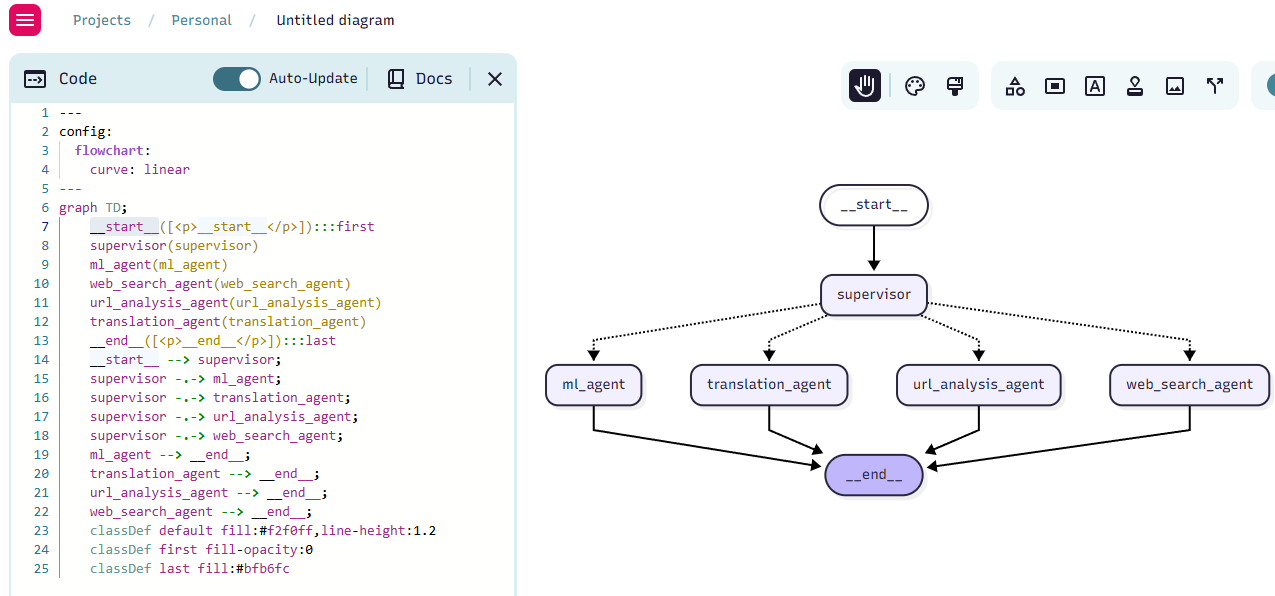